In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def _calc_v(x, dt):
    # x is in mu
    # dt is in hr
    return np.diff(x) / dt


def _calc_a(x, dt):
    # x is in mu
    # dt is in hr
    x_c = x[1:-1]
    x_after = x[2:]
    x_before = x[:-2]
    return (x_after - 2 * x_c + x_before) / dt**2


def compute_v_a(x, dt):
    v = _calc_v(x, dt)
    a = _calc_a(x, dt)
    df = pd.DataFrame(x[:-2], columns=["x"])
    df["v"] = v[:-1]
    df["a"] = a
    return df


def map_one_pair(x_v_a, nbins, dx, x_min, dv, v_min):

    acc_map = np.empty(shape=(nbins, nbins))
    acc_map[:] = np.nan

    x_v_a["xbin"] = np.floor((x_v_a.x.values - x_min) / dx)
    x_v_a["vbin"] = np.floor((x_v_a.v.values - v_min) / dv)

    x_v_a = x_v_a.astype({"xbin": "int"})
    x_v_a = x_v_a.astype({"vbin": "int"})

    for (xbin, vbin), df in x_v_a.groupby(["xbin", "vbin"]):
        acc_map[vbin, xbin] = df.a.mean()

    return acc_map


# Spring model

$\dfrac{dv}{dt}=-kx-cv+\sqrt{\sigma^2 \Delta t}\ \mathcal{N}(0, 1)$

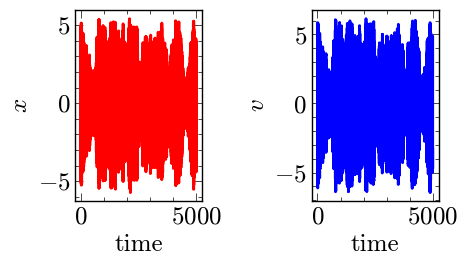

In [32]:
def sp_force(x, v):
    k = 1.3
    c = 0.013
    # if v > 0:
    #     return -k * x
    # return -k * x - c * v
    v = np.where(v < 0, v, np.exp(-x))
    return -k * x - c * v

dt = 0.01
N = 500000
sigma_sqrd = 0.1

x_0 = 2
v_0 = -5
a_0 = sp_force(x_0, v_0)

x_arr, v_arr, a_arr = [x_0], [v_0], [a_0]
temp = []

for n in range(1, N):
    
    noise = np.sqrt(sigma_sqrd * dt) * np.random.randn()
    
    x_n = x_arr[n-1]
    v_n = v_arr[n-1]
    a_n = a_arr[n-1]

    temp.append([noise, a_n])
    
    x_n1 = x_n + v_n * dt
    v_n1 = v_n + a_n * dt + noise
    a_n1 = sp_force(x_n1, v_n1)
    x_arr.append(x_n1)
    v_arr.append(v_n1)
    a_arr.append(a_n1)

plt.figure(figsize=(5, 3))
plt.subplot(121)
plt.plot(np.arange(N) * dt, x_arr, color="red")
plt.xlabel("time")
plt.ylabel(r"$x$")
plt.subplot(122)
plt.plot(np.arange(N) * dt, v_arr, color="blue")
plt.xlabel("time")
plt.ylabel(r"$v$")
plt.tight_layout()
plt.show()

In [30]:
temp

[[-0.12701010943795973, -2.535],
 [-0.09683072656706282, -2.4680193185773067],
 [0.0646920804500573, -2.3994589951978265],
 [0.14243142181998752, -2.331427739194821],
 [0.09967013150704399, -2.26494500606938],
 [0.07127449539255074, -2.199463541802742],
 [-0.08482283845272436, -2.1346227157157727],
 [-0.004631141481163526, -2.0684016917758745],
 [-0.048684849435105405, -2.0018515707767905],
 [-0.1873139695123793, -1.9344083060308492],
 [0.05950053013708966, -1.8642784866014628],
 [-0.14600250293528214, -1.7946798178606007],
 [-0.02495551414138548, -1.722949808205258],
 [-0.012620960009239507, -1.6506713933910104],
 [-0.16579507890468892, -1.578014318815502],
 [0.09438949581689525, -1.5029967663527866],
 [-0.17798279862033267, -1.429010887756065],
 [0.10043007001173232, -1.3525254613618705],
 [0.13785437145744164, -1.2771697975678518],
 [0.0687673003336431, -1.2034402085290958],
 [-0.08132340185296665, -1.130448147167569],
 [0.05858018615386861, -1.0562519233228211],
 [0.014513480448597

In [27]:
print(np.array(temp).mean(axis=0))

[3.97346501e-05            nan]


/home/pedrom/miniconda3/envs/ccam/lib/python3.10/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


In [22]:
data = pd.DataFrame(x_arr, columns=["x"])
x_v_a = compute_v_a(data.x.values, dt=0.01)
x_v_a = x_v_a.iloc[2:]

In [23]:
x_min = x_v_a.x.min()
x_max = x_v_a.x.max()
v_min = x_v_a.v.min()
v_max = x_v_a.v.max()
a_min = x_v_a.a.min()
a_max = x_v_a.a.max()

print(f"x: [{x_min:.3f}, {x_max:.3f}] mu")
print(f"v: [{v_min:.3f}, {v_max:.3f}] mu/hr")
print(f"a: [{a_min:.3f}, {a_max:.3f}] mu/hr^2")


x: [-5.800, 5.307] mu
v: [-6.485, 5.821] mu/hr
a: [-17.913, 18.143] mu/hr^2


Define one acceleration map bounds for everyone

In [24]:
nbins = 50
dx = (x_max - x_min) / (nbins - 1)
dv = (v_max - v_min) / (nbins - 1)

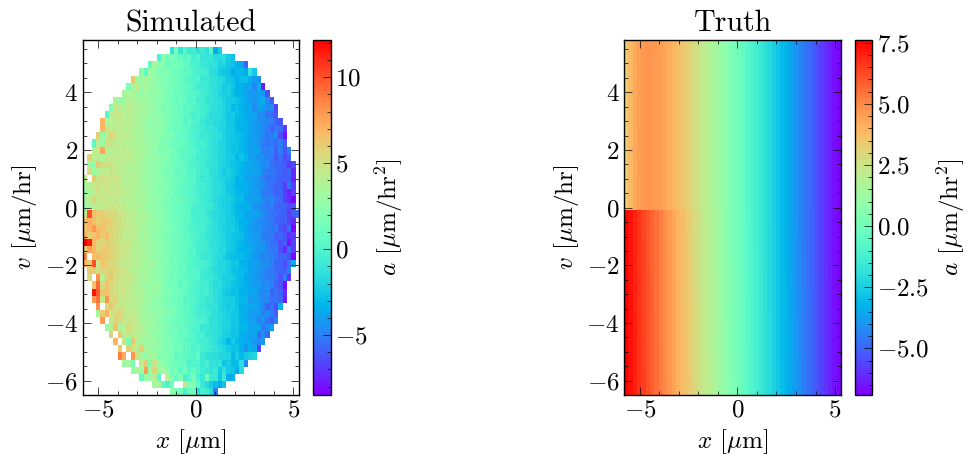

In [25]:
a_maps_mean = map_one_pair(x_v_a, nbins, dx, x_min, dv, v_min)

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.title("Simulated")
plt.imshow(
    a_maps_mean, origin="lower", extent=[x_min, x_max, v_min, v_max], cmap="rainbow"
)
cbar = plt.colorbar()
plt.xlabel(r"$x$ [$\mu$m]")
plt.ylabel(r"$v$ [$\mu$m/hr]")
cbar.set_label(r"$a$ [$\mu$m/hr$^2$]")
plt.axis("auto")

######### TRUTH #########
x = np.linspace(x_min, x_max, nbins)
v = np.linspace(v_min, v_max, nbins)
grid = np.meshgrid(x, v)

a = sp_force(grid[0], grid[1])

plt.subplot(122)
plt.title("Truth")
plt.imshow(a, extent=[x_min, x_max, v_min, v_max], origin="lower", cmap="rainbow")
cbar = plt.colorbar()
plt.xlabel(r"$x$ [$\mu$m]")
plt.ylabel(r"$v$ [$\mu$m/hr]")
cbar.set_label(r"$a$ [$\mu$m/hr$^2$]")
plt.axis("auto")

plt.tight_layout()
plt.subplots_adjust(wspace=1)
plt.show()
